In [57]:
import pandas as pd
import geopandas as gpd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from statsmodels.tools.tools import add_constant
import numpy as np
import statsmodels.api as sm
from tabulate import tabulate

### Load data

Load dataset with snapshot of 2014 pipeline snapshot and outcomes.

In [2]:
mv_history = pd.read_csv('./data/pipeline_history.csv')

The variable 'Built' indicates how much of the project was built by June 2022. The variable 'Units' indicates how large the project was as of June 2014 - or, if the project had no size listed in 2014, then the eventual size of the project. The variable 'Pg' indicates what page of the [2014 Planning Division Update](https://web.archive.org/web/20140709150825/http://mountainview.gov/civicax/filebank/blobdload.aspx?BlobID=13170) the project is listed on. This dataframe was created manually by reading the 2014 PDU.

In [3]:
mv_history.head()

,address,page,pct_built,units
0,420 San Antonio Road,3,1.00,373
1,2580 California Street,4,0.26,632
2,1701 W. El Camino Real,7,1.00,24
3,1101 W. El Camino Real,8,1.00,52
4,801 W. El Camino Real,8,1.00,164


Load site inventory datasets.

In [4]:
si_geo = gpd.read_file('./data/MV_Site_Inventory/MV_Site_Inventory.shp')

In [5]:
si = pd.read_csv('./data/hcd_table_a.csv', low_memory=False)
si = si[~si.isna().all(axis=1)]
si = si[:-1]

In [6]:
permits = gpd.read_file('./data/all_permits.json')

In [9]:
zoning = gpd.read_file('./data/Zoning_Districts/Zoning_Districts.shp')

### Pending Projects History Analysis

In [10]:
sum(mv_history.units * mv_history.pct_built) / mv_history.units.sum()

0.6646353322528363

What would a 33% discount factor do to the city's projections?

In [11]:
# city projections
tot_pipe = 6913
li_pipe = 1896

# expected total units
sum(mv_history.units * mv_history.pct_built) / mv_history.units.sum() * tot_pipe

4594.624051863858

In [12]:
# delta
tot_pipe - sum(mv_history.units * mv_history.pct_built) / mv_history.units.sum() * tot_pipe

2318.375948136142

In [13]:
# expected li units 
sum(mv_history.units * mv_history.pct_built) / mv_history.units.sum() * li_pipe

1260.1485899513777

In [14]:
# delta (li)
li_pipe - sum(mv_history.units * mv_history.pct_built) / mv_history.units.sum() * li_pipe

635.8514100486223

In [15]:
pearsonr(mv_history.units, mv_history.pct_built)

PearsonRResult(statistic=-0.15362040968120397, pvalue=0.5178707812714505)

### Opportunity Sites

In [16]:
opps = si[~si['Site Status'].str.contains('Pending')]

In [17]:
opps['Zoning Designation (Current)'].value_counts()

P(38) - El Camino Real Precise Plan    55
P(41) - East Whisman Precise Plan      15
P(40) - San Antonio Precise Plan        9
P(39) - North Bayshore Precise Plan     6
CN                                      5
CRA                                     4
P(27) - Grant-Phyllis Precise Plan      2
P(19) - Downtown Precise Plan           1
Name: Zoning Designation (Current), dtype: int64

Find opportunity sites for each of four major precise plan areas.

In [18]:
ecr = opps[opps['Zoning Designation (Current)'].str.contains("El Camino Real")]
ew = opps[opps['Zoning Designation (Current)'].str.contains("East Whisman")]
sa = opps[opps['Zoning Designation (Current)'].str.contains("San Antonio")]
nb = opps[opps['Zoning Designation (Current)'].str.contains("North Bayshore")]

There are 55 opportunity sites in El Camino Real Precise Plan, 15 in the East Whisman precise plan, 9 in the San Antonio precise plan, and 6 in the North Bayshore precise plan.

In [19]:
len(ecr), len(ew), len(sa), len(nb)

(55, 15, 9, 6)

### Cleaning permits dataset

Half of older permits have same geometry.

In [20]:
permits.apn = permits.apn.str.split('-').str.join('')

In [21]:
permits.apn = permits.apn.str.replace('Â\xa0', '').values.tolist()

In [22]:
permits.apn = permits.apn.str.strip()

In [23]:
permits = permits[(~permits.apn.duplicated()) | (permits.apn.isnull())]

In [24]:
permits = gpd.sjoin(permits, zoning.to_crs('EPSG:4326'))

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([2018. , 2018.3, 2018.6, 2018.9, 2019.2, 2019.5, 2019.8, 2020.1,
        2020.4, 2020.7, 2021. ]),
 <BarContainer object of 10 artists>)

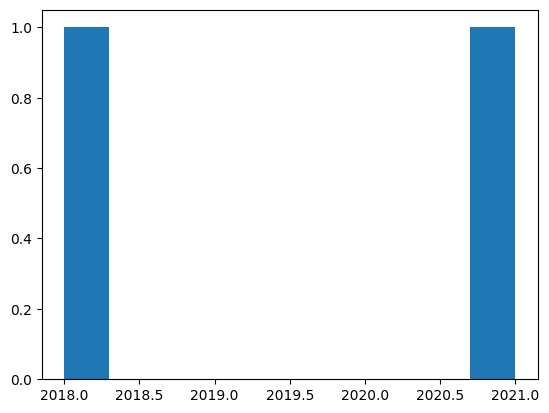

In [25]:
plt.hist(permits[permits.PRECPLAN == 'P(39)'].permyear)

In [26]:
pp_permits = permits['PRECPLAN'].value_counts()

In [27]:
ecr_ppid = 'P(38)'
nbs_ppid = 'P(39)'
sa_ppid = 'P(40)'
ew_ppid = 'P(41)'

In [28]:
ecr_yrs, ew_yrs, sa_yrs, nbs_yrs = 8, 3, 8, 5

In [29]:
ecr_exp = pp_permits[ecr_ppid] / ecr_yrs * 8

In [30]:
pp_permits[ecr_ppid] / ecr_yrs

3.125

In [31]:
nbs_exp = pp_permits[nbs_ppid] / nbs_yrs * 8

In [32]:
pp_permits[nbs_ppid] / nbs_yrs

0.4

In [33]:
sa_exp = pp_permits[sa_ppid] / sa_yrs * 8

In [34]:
pp_permits[sa_ppid] / sa_yrs

0.875

In [35]:
ew_exp = pp_permits[ew_ppid] / ew_yrs * 8

In [36]:
pp_permits[ew_ppid] / ew_yrs

0.6666666666666666

In [37]:
for pp, name, expect in zip([ecr, ew, sa, nb], ['ecr', 'ew', 'sa', 'nb'], [ecr_exp, ew_exp, sa_exp, nbs_exp]):
    print('For', name, 'the city claims', len(pp), 'projects in 8 years', ' but historical trends suggest')
    print(int(round(expect, 0)), "is more reasonable. That'd discount their site capacity claims by", round(1 - (int(round(expect,0)) / len(pp)), 2), '%')
    print('\n')

For ecr the city claims 55 projects in 8 years  but historical trends suggest
25 is more reasonable. That'd discount their site capacity claims by 0.55 %


For ew the city claims 15 projects in 8 years  but historical trends suggest
5 is more reasonable. That'd discount their site capacity claims by 0.67 %


For sa the city claims 9 projects in 8 years  but historical trends suggest
7 is more reasonable. That'd discount their site capacity claims by 0.22 %


For nb the city claims 6 projects in 8 years  but historical trends suggest
3 is more reasonable. That'd discount their site capacity claims by 0.5 %




In [38]:
for pp, name, expect in zip([ecr, ew, sa, nb], ['ecr', 'ew', 'sa', 'nb'], [ecr_exp, ew_exp, sa_exp, nbs_exp]):
    print('For', name, 'the city claims', len(pp), 'projects in 8 years, but historical trends suggest')
    print(int(round(expect, 0)), "is more reasonable. That'd inflate their site capacity claims by", 
          round((len(pp) / expect)*100 - 100), '%')
    print('\n')

For ecr the city claims 55 projects in 8 years, but historical trends suggest
25 is more reasonable. That'd inflate their site capacity claims by 120 %


For ew the city claims 15 projects in 8 years, but historical trends suggest
5 is more reasonable. That'd inflate their site capacity claims by 181 %


For sa the city claims 9 projects in 8 years, but historical trends suggest
7 is more reasonable. That'd inflate their site capacity claims by 29 %


For nb the city claims 6 projects in 8 years, but historical trends suggest
3 is more reasonable. That'd inflate their site capacity claims by 88 %




In [39]:
# from table 55
ew_li, ew_tot = 997, 1312
ecr_li, ecr_tot = 1283, 2530
nb_li, nb_tot = 313, 405
sa_li, sa_tot = 182, 325

run_sum_li, run_sum_tot = 0, 0

In [40]:
for pp, name, expect, li, tot in zip([ecr, ew, sa, nb], 
                                ['ecr', 'ew', 'sa', 'nb'], 
                                [ecr_exp, ew_exp, sa_exp, nbs_exp],
                                [ecr_li, ew_li, sa_li, nb_li],
                                [ecr_tot, ew_tot, sa_tot, nb_tot]):
    print('For', name, round(li*(1 - expect / len(pp))), 'li units are overstated')
    print('\n')
    print('For', name, round(tot*(1 - expect / len(pp))), 'total units are overstated')
    print('\n')
    run_sum_li += li*(1 - expect / len(pp))
    run_sum_tot += tot*(1 - expect / len(pp))

For ecr 700 li units are overstated


For ecr 1380 total units are overstated


For ew 643 li units are overstated


For ew 846 total units are overstated


For sa 40 li units are overstated


For sa 72 total units are overstated


For nb 146 li units are overstated


For nb 189 total units are overstated




In [41]:
for pp, name, expect, li, tot in zip([ecr, ew, sa, nb], 
                                ['ecr', 'ew', 'sa', 'nb'], 
                                [ecr_exp, ew_exp, sa_exp, nbs_exp],
                                [ecr_li, ew_li, sa_li, nb_li],
                                [ecr_tot, ew_tot, sa_tot, nb_tot]):
    print('For', name, round(li*(expect / len(pp))), 'li units are accommodated per mv yimby')
    print('\n')
    print('For', name, round(tot*(expect / len(pp))), 'total units are accommodated per mv yimby')
    print('\n')
    run_sum_li += li*(1 - expect / len(pp))
    run_sum_tot += tot*(1 - expect / len(pp))

For ecr 583 li units are accommodated per mv yimby


For ecr 1150 total units are accommodated per mv yimby


For ew 354 li units are accommodated per mv yimby


For ew 466 total units are accommodated per mv yimby


For sa 142 li units are accommodated per mv yimby


For sa 253 total units are accommodated per mv yimby


For nb 167 li units are accommodated per mv yimby


For nb 216 total units are accommodated per mv yimby




In [42]:
# total li units overstated 
run_sum_li

3057.6808080808078

In [43]:
#total units overstated 
run_sum_tot

4973.466666666667

In [44]:
5502 - run_sum_tot

528.5333333333328

In [45]:
3240 - run_sum_li

182.31919191919224

In [46]:
2775 + 465


3240

In [47]:
4698 + 804

5502

## Replicating for November Update

In [48]:
si_nov = pd.read_csv('./data/nov_table_a.csv', low_memory=False)
si_nov = si_nov[~si_nov.isna().all(axis=1)]
si_nov = si_nov[:-1]
si_nov.head()

,Jurisdiction Name,Site Address/Intersection,5 Digit ZIP Code,Assessor Parcel Number,Consolidated Sites,General Plan Designation (Current),Zoning Designation (Current),Minimum Density Allowed (units/acre),Max Density Allowed (units/acre),Parcel Size (Acres),...,Site Status,Identified in Last/Last Two Planning Cycle(s),Lower Income Capacity,Moderate Income Capacity,Above Moderate Income Capacity,Total Capacity,Optional Information 1,Optional Information 2,Optional Information 3,Unnamed: 22
0,MOUNTAIN VIEW,1500 SHORELINE BL,94043-1314,11613030.0,Not Applicable,North Bayshore Mixed-Use,P(39) - North Bayshore Precise Plan,0.0,~157,15.75,...,Available,Not Used in Prior Housing Element,150.0,150.0,1432.0,1732.0,Opportunity Site,Maximum Density set by FAR (3.5). Maximum dwel...,NaN,NaN
1,MOUNTAIN VIEW,1280 SPACE PARK WY,94043-1434,11614071.0,Not Applicable,North Bayshore Mixed-Use,P(39) - North Bayshore Precise Plan,0.0,~157,0.98,...,Available,Not Used in Prior Housing Element,107.0,0.0,0.0,107.0,Opportunity Site,Maximum Density set by FAR (3.5). Maximum dwel...,NaN,NaN
2,MOUNTAIN VIEW,1060 LA AVENIDA,94043-1422,11614107.0,Not Applicable,North Bayshore Mixed-Use,P(39) - North Bayshore Precise Plan,0.0,~71,1.24,...,Available,Not Used in Prior Housing Element,61.0,0.0,0.0,61.0,Opportunity Site,Maximum Density set by FAR (1.85). Maximum dwe...,NaN,NaN
3,MOUNTAIN VIEW,1070 LA AVENIDA,94043-1422,11614108.0,Not Applicable,North Bayshore Mixed-Use,P(39) - North Bayshore Precise Plan,0.0,~71,1.07,...,Available,Not Used in Prior Housing Element,53.0,0.0,0.0,53.0,Opportunity Site,Maximum Density set by FAR (1.85). Maximum dwe...,NaN,NaN
4,MOUNTAIN VIEW,1080 LA AVENIDA A,94043-1422,11614109.0,Not Applicable,North Bayshore Mixed-Use,P(39) - North Bayshore Precise Plan,0.0,~71,0.92,...,Available,Not Used in Prior Housing Element,0.0,45.0,0.0,45.0,Opportunity Site,Maximum Density set by FAR (1.85). Maximum dwe...,NaN,NaN


#### Pipeline

In [49]:
# city projections
tot_pipe = 7476
li_pipe = 1992

# expected total pipeline units
print(round(sum(mv_history.units * mv_history.pct_built) / mv_history.units.sum() * tot_pipe))

# delta
print(round(tot_pipe - sum(mv_history.units * mv_history.pct_built) / mv_history.units.sum() * tot_pipe))

# expected li pipeline units 
print(round(sum(mv_history.units * mv_history.pct_built) / mv_history.units.sum() * li_pipe))

# delta (li)
print(round(li_pipe - sum(mv_history.units * mv_history.pct_built) / mv_history.units.sum() * li_pipe))

4969
2507
1324
668


In [50]:
opps = si_nov[~si_nov['Site Status'].str.contains('Pending')]
opps['Zoning Designation (Current)'].value_counts()

P(38) - El Camino Real Precise Plan    52
P(41) - East Whisman Precise Plan      15
P(40) - San Antonio Precise Plan        9
P(39) - North Bayshore Precise Plan     7
CN                                      5
CRA                                     4
P(27) - Grant-Phyllis Precise Plan      3
P(19) - Downtown Precise Plan           1
Name: Zoning Designation (Current), dtype: int64

In [59]:
ecr = opps[opps['Zoning Designation (Current)'].str.contains("El Camino Real")]
ew = opps[opps['Zoning Designation (Current)'].str.contains("East Whisman")]
sa = opps[opps['Zoning Designation (Current)'].str.contains("San Antonio")]
nb = opps[opps['Zoning Designation (Current)'].str.contains("North Bayshore")]
pp_inflations = {}

In [63]:
for pp, name, expect in zip([ecr, ew, sa, nb], ['ecr', 'ew', 'sa', 'nb'], [ecr_exp, ew_exp, sa_exp, nbs_exp]):
    pp_inflations[name] = {'inflate':  round((len(pp) / expect)*100 - 100, 2),
                            'claim': round(float(len(pp)) / 8.0, 3), 
                            'hist': round(expect / 8, 3)}

In [64]:
# Table 2
print(tabulate([['EW', pp_inflations['ew']['hist'], pp_inflations['ew']['claim'], pp_inflations['ew']['inflate']],
                ['ECR', pp_inflations['ecr']['hist'], pp_inflations['ecr']['claim'], pp_inflations['ecr']['inflate']],
                ['NB', pp_inflations['nb']['hist'], pp_inflations['nb']['claim'], pp_inflations['nb']['inflate']],
                ['SA', pp_inflations['sa']['hist'], pp_inflations['sa']['claim'], pp_inflations['sa']['inflate']]], 
               headers=['Precise Plan', 'Historical', 'Claimed', 'Inflation']))


Precise Plan      Historical    Claimed    Inflation
--------------  ------------  ---------  -----------
EW                     0.667      1.875       181.25
ECR                    3.125      6.5         108
NB                     0.4        0.875       118.75
SA                     0.875      1.125        28.57


In [65]:
# from table 62 (november)
ew_li, ew_tot = 997, 1312
ecr_li, ecr_tot = 1127, 1905
nb_li, nb_tot = 463, 2137
sa_li, sa_tot = 191, 310

run_sum_li, run_sum_tot = 0, 0

In [66]:
pp_expecteds = {}
for pp, name, expect, li, tot in zip([ecr, ew, sa, nb], 
                                ['ecr', 'ew', 'sa', 'nb'], 
                                [ecr_exp, ew_exp, sa_exp, nbs_exp],
                                [ecr_li, ew_li, sa_li, nb_li],
                                [ecr_tot, ew_tot, sa_tot, nb_tot]):
    pp_expecteds[name] = {'li': round(li*(expect / len(pp)), 2), 'tot': round(tot*(expect / len(pp)), 2)} 
    run_sum_li += li*(1 - expect / len(pp))
    run_sum_tot += tot*(1 - expect / len(pp))

In [67]:
run_sum_li


1521.4714896214896

In [68]:
run_sum_tot

3063.6203296703297

In [69]:
# Create Table 3


In [70]:
four_pp_li = ew_li + ecr_li + nb_li + sa_li
four_pp_tot = ew_tot + ecr_tot + nb_tot + sa_tot
all_expected_li = sum([v['li'] for k, v in pp_expecteds.items()])
all_expected_tot = sum([v['tot'] for k, v in pp_expecteds.items()])
print(tabulate([['EW', 'li', ew_li, pp_expecteds['ew']['li'], ew_li - pp_expecteds['ew']['li']],
                ['EW', 'tot', ew_tot, pp_expecteds['ew']['tot'], ew_tot - pp_expecteds['ew']['tot']],
                ['ECR', 'li', ecr_li, pp_expecteds['ecr']['li'], ecr_li - pp_expecteds['ecr']['li']],
                ['ECR', 'tot', ecr_tot, pp_expecteds['ecr']['tot'], ecr_tot - pp_expecteds['ecr']['tot']],
                ['NB', 'li', nb_li, pp_expecteds['nb']['li'], nb_li - pp_expecteds['nb']['li']],
                ['NB', 'tot', nb_tot, pp_expecteds['nb']['tot'], nb_tot - pp_expecteds['nb']['tot']],
                ['SA', 'li', sa_li, pp_expecteds['sa']['li'], sa_li - pp_expecteds['sa']['li']],
                ['SA', 'tot', sa_tot, pp_expecteds['sa']['tot'], sa_tot - pp_expecteds['sa']['tot']],
                ['All Four', 'li', four_pp_li, all_expected_li, four_pp_li - all_expected_li],
                ['All Four', 'tot', four_pp_tot, all_expected_tot, four_pp_tot - all_expected_tot]], 
               headers=['Precise Plan', 'income', 'MVPlanning', 'MVYIMBY', 'DIFFERENCE']))


Precise Plan    income      MVPlanning    MVYIMBY    DIFFERENCE
--------------  --------  ------------  ---------  ------------
EW              li                 997     354.49        642.51
EW              tot               1312     466.49        845.51
ECR             li                1127     541.83        585.17
ECR             tot               1905     915.87        989.13
NB              li                 463     211.66        251.34
NB              tot               2137     976.91       1160.09
SA              li                 191     148.56         42.44
SA              tot                310     241.11         68.89
All Four        li                2778    1256.54       1521.46
All Four        tot               5664    2600.38       3063.62


In [71]:
ew_li, ew_tot = 997, 1312
ecr_li, ecr_tot = 1127, 1905
nb_li, nb_tot = 463, 2137
sa_li, sa_tot = 191, 310

In [72]:
# Add downtown, grant-phyllis, and not-in-pp to LI credit 
1257 + 148 + 0 + 201

1606

In [73]:
# Add downtown, grant-phyllis, and not-in-pp to total credit 
2600 + 273 + 6 + 322

3201

### Approved projects

In [78]:
# See https://docs.google.com/spreadsheets/d/1dOutYacAJ_BmBkRc1_Vdt9l6PV9boGpC3FOcniIvrEk/edit#gid=0
gamel_li, gamel_tot = 29, 92
ecr950_li, ecr950_tot = 70, 71
logue_li, logue_tot = 24, 408
cal2580_li, cal2580_tot = 0, 165
ecr870_li, ecr_870_tot = 33, 191

In [95]:
gamel_li + logue_li + ecr870_li 

86

In [97]:
509 - 86

423

In [98]:
gamel_tot + logue_tot + ecr_870_tot

691

In [100]:
423 + 1324 + 1606 + 30

3383

In [99]:
3942 - 691

3251

In [101]:
3251 + 4969 + 3201 + 59

11480

In [102]:
691 + 2507 + 3064 + 37

6299

In [103]:
86 + 668 + 1521 + 18 

2293

In [106]:
17779 - 6299

11480

In [91]:
opps

,Jurisdiction Name,Site Address/Intersection,5 Digit ZIP Code,Assessor Parcel Number,Consolidated Sites,General Plan Designation (Current),Zoning Designation (Current),Minimum Density Allowed (units/acre),Max Density Allowed (units/acre),Parcel Size (Acres),...,Site Status,Identified in Last/Last Two Planning Cycle(s),Lower Income Capacity,Moderate Income Capacity,Above Moderate Income Capacity,Total Capacity,Optional Information 1,Optional Information 2,Optional Information 3,Unnamed: 22
0,MOUNTAIN VIEW,1500 SHORELINE BL,94043-1314,11613030.0,Not Applicable,North Bayshore Mixed-Use,P(39) - North Bayshore Precise Plan,0.0,~157,15.75,...,Available,Not Used in Prior Housing Element,150.0,150.0,1432.0,1732.0,Opportunity Site,Maximum Density set by FAR (3.5). Maximum dwel...,NaN,NaN
1,MOUNTAIN VIEW,1280 SPACE PARK WY,94043-1434,11614071.0,Not Applicable,North Bayshore Mixed-Use,P(39) - North Bayshore Precise Plan,0.0,~157,0.98,...,Available,Not Used in Prior Housing Element,107.0,0.0,0.0,107.0,Opportunity Site,Maximum Density set by FAR (3.5). Maximum dwel...,NaN,NaN
2,MOUNTAIN VIEW,1060 LA AVENIDA,94043-1422,11614107.0,Not Applicable,North Bayshore Mixed-Use,P(39) - North Bayshore Precise Plan,0.0,~71,1.24,...,Available,Not Used in Prior Housing Element,61.0,0.0,0.0,61.0,Opportunity Site,Maximum Density set by FAR (1.85). Maximum dwe...,NaN,NaN
3,MOUNTAIN VIEW,1070 LA AVENIDA,94043-1422,11614108.0,Not Applicable,North Bayshore Mixed-Use,P(39) - North Bayshore Precise Plan,0.0,~71,1.07,...,Available,Not Used in Prior Housing Element,53.0,0.0,0.0,53.0,Opportunity Site,Maximum Density set by FAR (1.85). Maximum dwe...,NaN,NaN
4,MOUNTAIN VIEW,1080 LA AVENIDA A,94043-1422,11614109.0,Not Applicable,North Bayshore Mixed-Use,P(39) - North Bayshore Precise Plan,0.0,~71,0.92,...,Available,Not Used in Prior Housing Element,0.0,45.0,0.0,45.0,Opportunity Site,Maximum Density set by FAR (1.85). Maximum dwe...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,MOUNTAIN VIEW,121 E EL CAMINO REAL,94040-2701,19742004.0,Not Applicable,Mixed-Use Corridor (ECR Village Center),P(38) - El Camino Real Precise Plan,0.0,47-93,7.96,...,Available,Not Used in Prior Housing Element,96.0,0.0,0.0,96.0,Opportunity Site - El Camino Real,Maximum Density set by FAR (1.85). Maximum dwe...,"Rezoned to 2.3 FAR, allowing approximately 65-...",NaN
92,MOUNTAIN VIEW,789 E EL CAMINO REAL,94040-2833,19801003.0,Not Applicable,Mixed-Use Corridor,P(38) - El Camino Real Precise Plan,0.0,65-111,4.59,...,Available,Not Used in Prior Housing Element,55.0,0.0,0.0,55.0,Opportunity Site,Maximum Density set by FAR (1.85). Maximum dwe...,NaN,NaN
93,MOUNTAIN VIEW,825 E EL CAMINO REAL,94040-2807,19807003.0,Not Applicable,Mixed-Use Corridor,P(38) - El Camino Real Precise Plan,0.0,65-111,0.29,...,Available,Not Used in Prior Housing Element,0.0,17.0,0.0,17.0,Opportunity Site,Maximum Density set by FAR (1.85). Maximum dwe...,NaN,NaN
94,MOUNTAIN VIEW,831 E EL CAMINO REAL,94040-2807,19807004.0,Not Applicable,Mixed-Use Corridor,P(38) - El Camino Real Precise Plan,0.0,65-111,1.16,...,Available,Not Used in Prior Housing Element,70.0,0.0,0.0,70.0,Opportunity Site,Maximum Density set by FAR (1.85). Maximum dwe...,NaN,NaN


In [94]:
opps[opps['Site Address/Intersection'].str.contains('1288')]

,Jurisdiction Name,Site Address/Intersection,5 Digit ZIP Code,Assessor Parcel Number,Consolidated Sites,General Plan Designation (Current),Zoning Designation (Current),Minimum Density Allowed (units/acre),Max Density Allowed (units/acre),Parcel Size (Acres),...,Site Status,Identified in Last/Last Two Planning Cycle(s),Lower Income Capacity,Moderate Income Capacity,Above Moderate Income Capacity,Total Capacity,Optional Information 1,Optional Information 2,Optional Information 3,Unnamed: 22
34,MOUNTAIN VIEW,1288 W EL CAMINO REAL,94040-2402,15430044.0,Not Applicable,Mixed-Use Corridor,P(38) - El Camino Real Precise Plan,0.0,65-111,0.96,...,Available,Not Used in Prior Housing Element,58.0,0.0,0.0,58.0,Opportunity Site,Maximum Density set by FAR (1.85). Maximum dwe...,NaN,NaN


### Changes to approved project

In [21]:
new_approvals = ("""1001 North Shoreline Blvd
1100 La Avenida
1255 Pear Ave
1313 and 1347 W El Camino Real
1411-1495 W El Camino
1720 Villa Street
1919 Gamel Way
1958 Latham St
198 Easy Street
2580-2590 California Street
2645 Fayette Drive
334 San Antonio Rd
400 Logue Avenue
555 East Evelyn Avenue
555 W Middlefield Rd
570 Rengstorff Ave
601 Escuela Ave
773 Cuesta Drive
777 W Middlefield Rd
828-836 Sierra Vista Ave, and 1975/1979 Colony St
851-853 Sierra Vista Avenue
870 E El Camino Real
901 E El Camino Real
950 West El Camino Real
City Lot 12 (Bryant St)""").split('\n')

In [25]:
old_approvals = (
"""1001 North Shoreline Boulevard
1100 La Avenida
1255 Pear Avenue
1313 and 1347 W El Camino Real
1919 Gamel Way
1958 Latham Street
198 Easy Street
2645 Fayette Drive
294 Tyrella Avenue
400 Logue Avenue
555 W Middlefield Rd
570 Rengstorff Avenue
601 Escuela Avenue
676 Dana Street
773 Cuesta Drive
777 W Middlefield Road
828-836 Sierra Vista Avenue, and 1975/1979 Colony Street
851-853 Sierra Vista Avenue
901 E El Camino Real
City Lot 12 (Bryant Street)
""").split('\n')

In [26]:
old_approvals = [name.replace("Avenue", "Ave") for name in old_approvals]
new_approvals = [name.replace("Avenue", "Ave") for name in new_approvals]

new_approvals = [name.replace("Road", "Rd") for name in new_approvals]
old_approvals = [name.replace("Road", "Rd") for name in old_approvals]

new_approvals = [name.replace("Street", "St") for name in new_approvals]
old_approvals = [name.replace("Street", "St") for name in old_approvals]

old_approvals = [name.replace("Boulevard", "Blvd") for name in old_approvals]
new_approvals = [name.replace("Boulevard", "Blvd") for name in new_approvals]

In [27]:
set(new_approvals) - set(old_approvals)

{'1411-1495 W El Camino',
 '1720 Villa St',
 '2580-2590 California St',
 '334 San Antonio Rd',
 '555 East Evelyn Ave',
 '870 E El Camino Real',
 '950 West El Camino Real'}